# Alice Logistic Regression Classification

In [725]:
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV

sns.set()
%config InlineBackend.figure_format = 'retina'

## Loading Data

In [5]:
PATH_TO_DATA = Path("../../_static/data/assignment4")

In [727]:
train_df = pd.read_csv(PATH_TO_DATA / "train_sessions.csv", index_col="session_id", parse_dates=times)
test_df = pd.read_csv(PATH_TO_DATA / "test_sessions.csv", index_col="session_id", parse_dates=times)
train_df = train_df.sort_values(by="time1")
train_df.head(10)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0
242171,952,2013-01-12 08:50:22,947.0,2013-01-12 08:50:23,953.0,2013-01-12 08:50:23,946.0,2013-01-12 08:50:23,947.0,2013-01-12 08:50:24,...,2013-01-12 08:50:24,953.0,2013-01-12 08:50:24,955.0,2013-01-12 08:50:24,946.0,2013-01-12 08:50:25,947.0,2013-01-12 08:50:25,0
57157,953,2013-01-12 08:50:25,947.0,2013-01-12 08:50:26,946.0,2013-01-12 08:50:26,953.0,2013-01-12 08:50:26,955.0,2013-01-12 08:50:26,...,2013-01-12 08:50:27,953.0,2013-01-12 08:50:27,946.0,2013-01-12 08:50:27,953.0,2013-01-12 08:50:28,1033.0,2013-01-12 08:50:28,0
240201,946,2013-01-12 08:50:28,947.0,2013-01-12 08:50:28,954.0,2013-01-12 08:50:28,953.0,2013-01-12 08:50:29,946.0,2013-01-12 08:50:29,...,2013-01-12 08:50:29,946.0,2013-01-12 08:50:30,956.0,2013-01-12 08:50:30,957.0,2013-01-12 08:50:31,956.0,2013-01-12 08:50:31,0
210686,946,2013-01-12 08:50:31,956.0,2013-01-12 08:50:32,946.0,2013-01-12 08:50:32,946.0,2013-01-12 08:50:33,955.0,2013-01-12 08:50:33,...,2013-01-12 08:50:33,946.0,2013-01-12 08:50:34,946.0,2013-01-12 08:50:35,946.0,2013-01-12 08:50:36,948.0,2013-01-12 08:50:36,0


Each row represents a user session. Each session is restricted such that there is a maximum of 10 sites visited and maximum of 30 minutes per session. i.e. a session ends when a user has visited 10 sites or spent 30 min online.

Columns in the dataset are such that
- **site**_n_ contains the website id of the _nth_ visited site in the session
- **time**_n_ contains the timestamp relating to when the _nth_ site was visited

A pickle file was also included with the datasets to link website id to site url

In [42]:
sites = ["site%s" % i for i in range(1, 11)]
# train_df[sites] = train_df[sites].fillna(0).astype(np.uint16)
# test_df[sites] = test_df[sites].fillna(0).astype(np.uint16)
train_df[sites] = train_df[sites].astype('Int64')
test_df[sites] = test_df[sites].astype('Int64')

with open(PATH_TO_DATA / "site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=["site"])
print(sites_dict.shape[0])
sites_dict.head()

48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


## Exploring Data

In [54]:
top_10_sites = (
    pd.Series(train_df[sites].values.flatten())
    .value_counts()
    .head(10)
)
sites_dict.loc[top_10_sites.index]

,site
21,www.google.fr
23,www.google.com
782,annotathon.org
22,apis.google.com
29,www.facebook.com
167,www.bing.com
780,blast.ncbi.nlm.nih.gov
778,www.ncbi.nlm.nih.gov
52,clients1.google.com
812,mail.google.com


In [56]:
top_10_alice = (
    pd.Series(train_df[train_df['target'] == 1][sites].values.flatten())
    .value_counts()
    .head(10))
sites_dict.loc[top_10_alice.index]

,site
77,i1.ytimg.com
80,s.youtube.com
76,www.youtube.com
29,www.facebook.com
21,www.google.fr
81,r4---sn-gxo5uxg-jqbe.googlevideo.com
879,r1---sn-gxo5uxg-jqbe.googlevideo.com
22,apis.google.com
75,s.ytimg.com
82,r2---sn-gxo5uxg-jqbe.googlevideo.com


#### Takeaways
- There are only 3 websites that occur in both the global top 10 sites and Alice's top 10 sites
- Alice visits mostly video streaming sites

In [90]:
# seperate df for alice data
alice_df = train_df[train_df['target'] == 1]

n_sites_train = pd.Series(train_df[sites].values.flatten()).nunique()
n_sites_alice = pd.Series(alice_df[sites].values.flatten()).nunique()
print(f'Alice has visited {n_sites_alice} unique websites in the training set')
print(f'There are {n_sites_train} unique websites in the whole training set')
print(f'Alice has visited {n_sites_alice / n_sites_train * 100} % of websites in the training set')

Alice has visited 1053 unique websites in the training set
There are 41601 unique websites in the whole training set
Alice has visited 2.5311891541068725 % of websites in the training set


In [215]:
# Seperate dataframe for working with times
time_df = pd.DataFrame(index=train_df.index)

time_df['min_time'] = train_df[times].min(axis=1)
time_df['max_time'] = train_df[times].max(axis=1)
time_df['year'] = time_df['min_time'].dt.year
time_df['month'] = time_df['min_time'].dt.month
time_df['year_month'] = time_df['year'] * 100 + time_df['month']
time_df['day'] = time_df['min_time'].dt.day
time_df['weekday'] = time_df['min_time'].dt.weekday
time_df['hour'] = time_df['min_time'].dt.hour
time_df['num_sites'] = train_df[sites].apply(lambda x: x.count(), axis=1)
time_df['session_length'] = (time_df['max_time'] - time_df['min_time']) / np.timedelta64(1, "s")
time_df['avg_time_on_site'] = time_df['session_length'] / time_df['num_sites']

time_df['target'] = train_df['target']
time_df

,min_time,max_time,year,month,year_month,day,weekday,hour,num_sites,session_length,avg_time_on_site,target
session_id,,,,,,,,,,,,
21669,2013-01-12 08:05:57,2013-01-12 08:05:57,2013,1,201301,12,5,8,2,0.0,0.000000,0
54843,2013-01-12 08:37:23,2013-01-12 09:07:09,2013,1,201301,12,5,8,4,1786.0,446.500000,0
77292,2013-01-12 08:50:13,2013-01-12 08:50:17,2013,1,201301,12,5,8,10,4.0,0.400000,0
114021,2013-01-12 08:50:17,2013-01-12 08:50:20,2013,1,201301,12,5,8,10,3.0,0.300000,0
146670,2013-01-12 08:50:20,2013-01-12 08:50:22,2013,1,201301,12,5,8,10,2.0,0.200000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
12224,2014-04-30 23:33:48,2014-04-30 23:34:00,2014,4,201404,30,2,23,10,12.0,1.200000,0
164438,2014-04-30 23:34:15,2014-04-30 23:37:13,2014,4,201404,30,2,23,10,178.0,17.800000,0
12221,2014-04-30 23:38:08,2014-04-30 23:38:36,2014,4,201404,30,2,23,10,28.0,2.800000,0


In [132]:
time_df.groupby('target')['session_length'].describe().T

target,0,1
count,251264.000000,2297.000000
mean,139.282372,52.296474
std,296.653518,153.309014
min,0.000000,0.000000
25%,7.000000,4.000000
50%,28.000000,11.000000
75%,114.000000,38.000000
max,1800.000000,1763.000000


<Axes: xlabel='session_length', ylabel='Probability'>

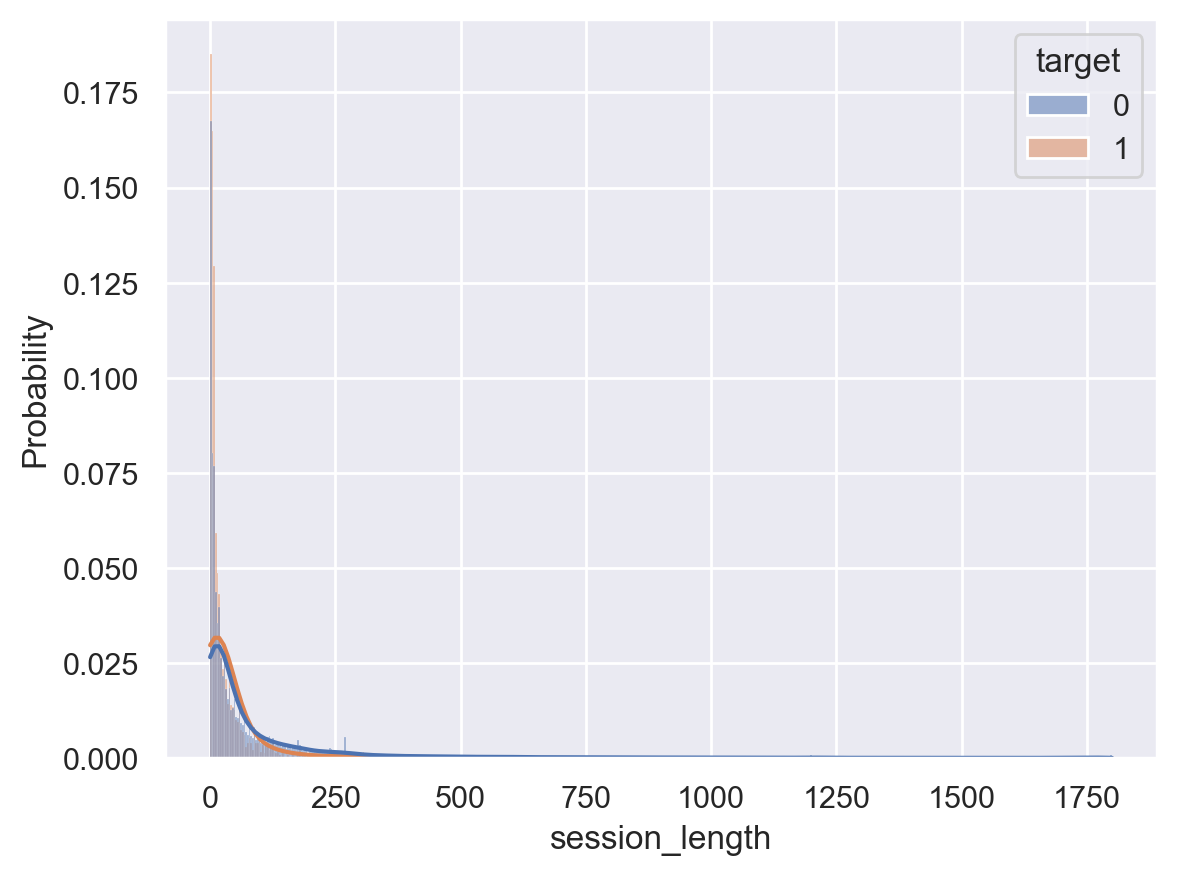

In [178]:
sns.histplot(
    x='session_length',
    hue='target',
    data=time_df,
    stat='probability',
    common_norm=False,
    kde=True)

<Axes: xlabel='session_length', ylabel='Density'>

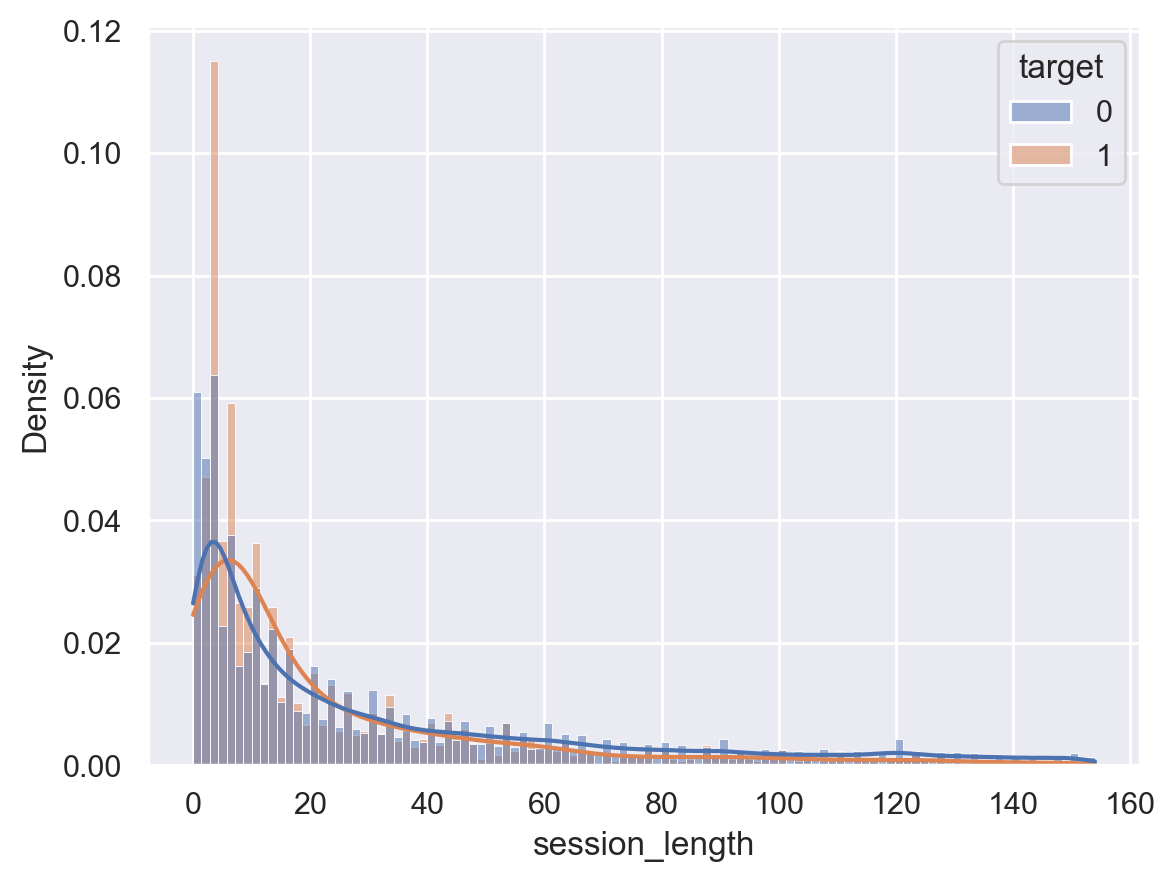

In [166]:
sns.histplot(
    x='session_length',
    hue='target',
    data=time_df[time_df['session_length'] < time_df['session_length'].quantile(0.8)],
    stat='density',
    common_norm=False,
    kde=True)

<Axes: xlabel='session_length'>

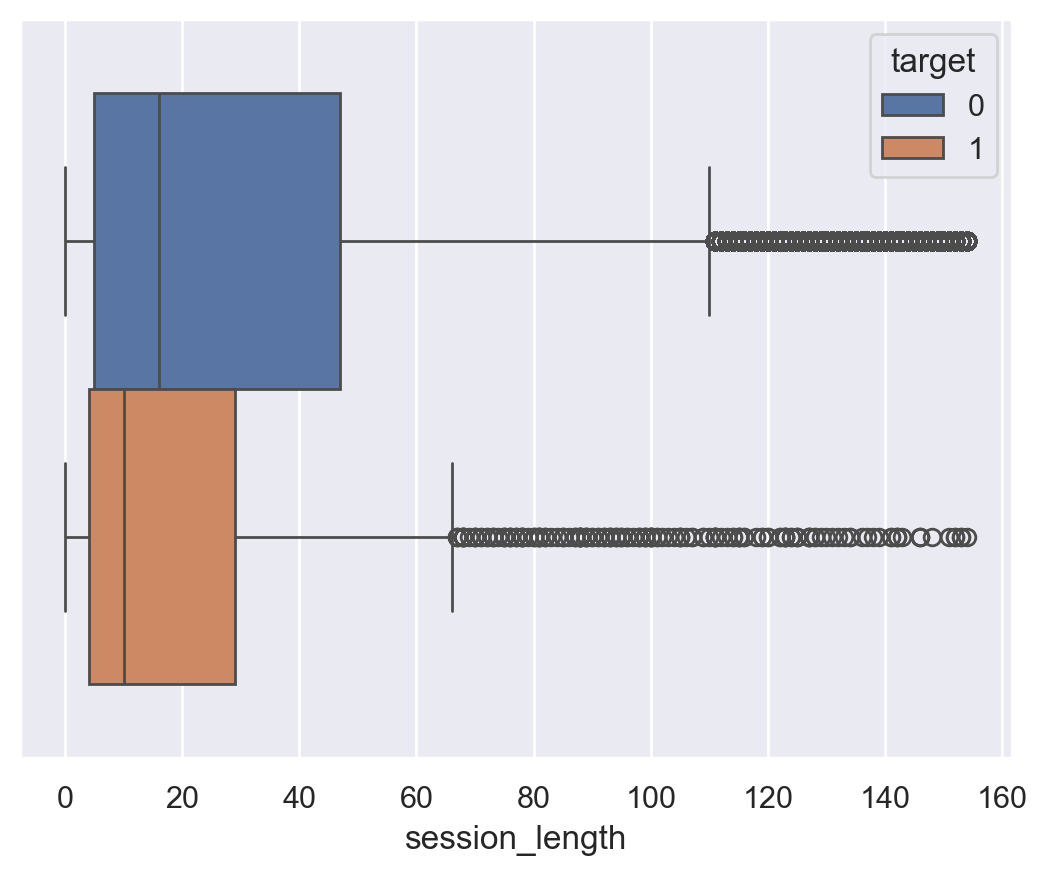

In [170]:
sns.boxplot(
    x='session_length',
    hue='target',
    data=time_df[time_df['session_length'] < time_df['session_length'].quantile(0.8)]
)

In [176]:
alice_skew = time_df.loc[time_df['target'] == 1, 'session_length'].skew()
not_alice_skew = time_df.loc[time_df['target'] == 0, 'session_length'].skew()
print(f'Skewness of Alice\'s session lengths: {alice_skew}')
print(f'Skewness of every other user session lengths: {not_alice_skew}')

Skewness of Alice's session lengths: 6.921317474769439
Skewness of every other user session lengths: 3.4594394565261353


### Takeaways
- **session_length** is heavily right skewed
- Alice's average session is shorter than other users in the dataset
- There is less variability in Alice's session length

### Insights
- If we want to use session_length as a feature in our model if must be log transformed and scaled

In [134]:
time_df.groupby('target')['avg_time_on_site'].describe().T

target,0,1
count,251264.000000,2297.000000
mean,16.803953,5.630960
std,45.149464,19.005033
min,0.000000,0.000000
25%,0.700000,0.400000
50%,2.800000,1.100000
75%,11.900000,3.800000
max,900.000000,405.250000


<Axes: xlabel='avg_time_on_site', ylabel='Probability'>

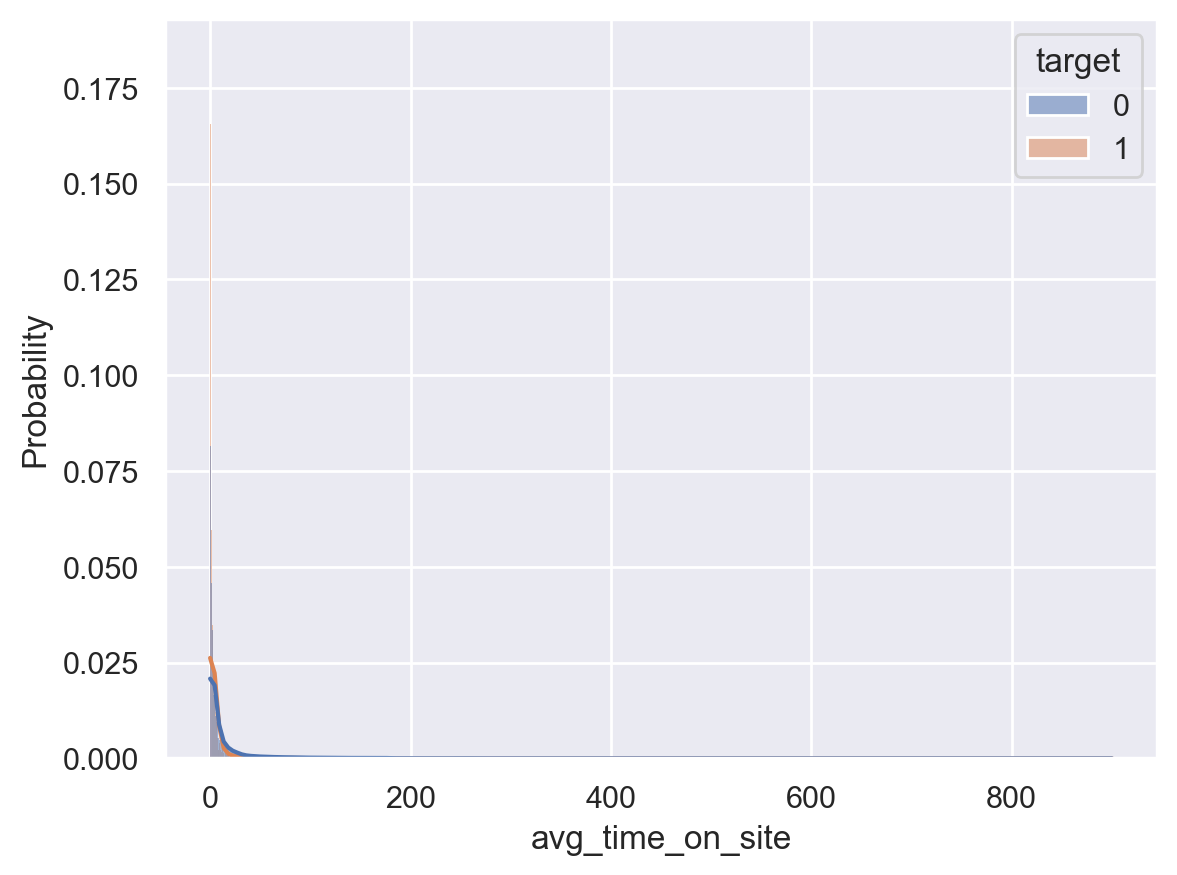

In [181]:
sns.histplot(
    x='avg_time_on_site',
    hue='target',
    data=time_df,
    stat='probability',
    common_norm=False,
    kde=True)

<Axes: xlabel='avg_time_on_site', ylabel='Density'>

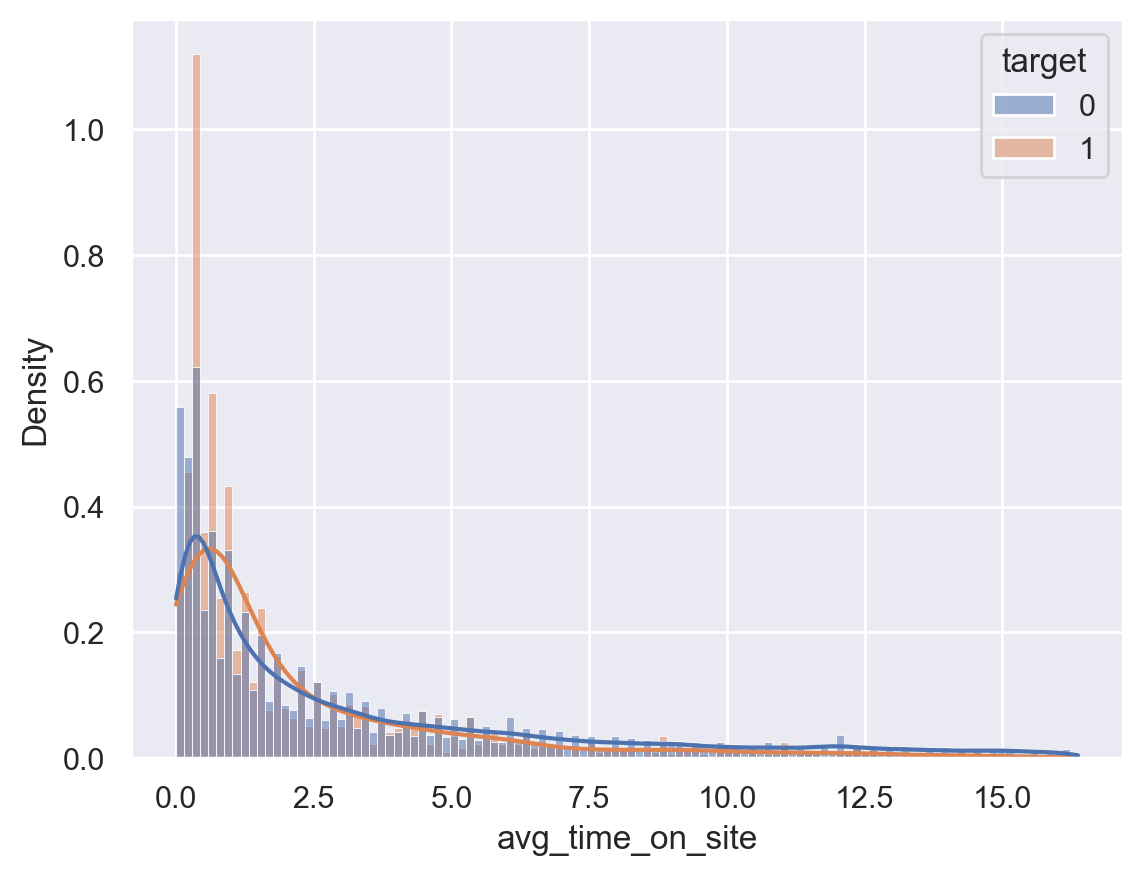

In [587]:
sns.histplot(
    x='avg_time_on_site',
    hue='target',
    data=time_df[time_df['avg_time_on_site'] < time_df['avg_time_on_site'].quantile(0.8)],
    stat='density',
    common_norm=False,
    kde=True)

<Axes: xlabel='avg_time_on_site'>

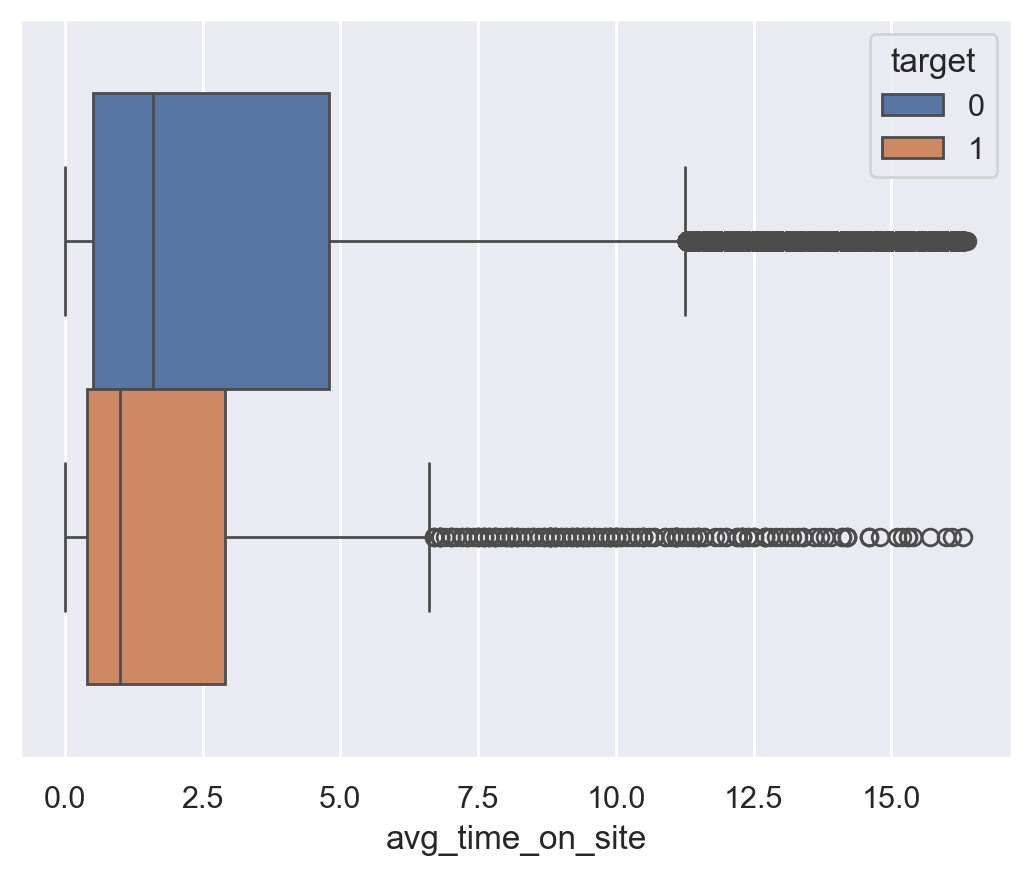

In [589]:
sns.boxplot(
    x='avg_time_on_site',
    hue='target',
    data=time_df[time_df['avg_time_on_site'] < time_df['avg_time_on_site'].quantile(0.8)]
)

### Takeaways
- Alice spends less time on websites on average per session

### Insights
- If we want to use session_length as a feature in our model if must be log transformed and scaled

In [136]:
time_df.groupby('target')['num_sites'].describe().T

target,0,1
count,251264.000000,2297.000000
mean,9.512350,9.912495
std,1.742295,0.734720
min,1.000000,1.000000
25%,10.000000,10.000000
50%,10.000000,10.000000
75%,10.000000,10.000000
max,10.000000,10.000000


    target  num_sites   count  proportion
0        0          1    3460    0.013770
1        0          2    3172    0.012624
2        0          3    2597    0.010336
3        0          4    2486    0.009894
4        0          5    2327    0.009261
5        0          6    2194    0.008732
6        0          7    2067    0.008226
7        0          8    2139    0.008513
8        0          9    2028    0.008071
9        0         10  228794    0.910572
10       1          1       3    0.001306
11       1          2       7    0.003047
12       1          3       1    0.000435
13       1          4       6    0.002612
14       1          5       7    0.003047
15       1          6       4    0.001741
16       1          7       6    0.002612
17       1          8       1    0.000435
18       1          9       4    0.001741
19       1         10    2258    0.983021


<Axes: xlabel='num_sites', ylabel='proportion'>

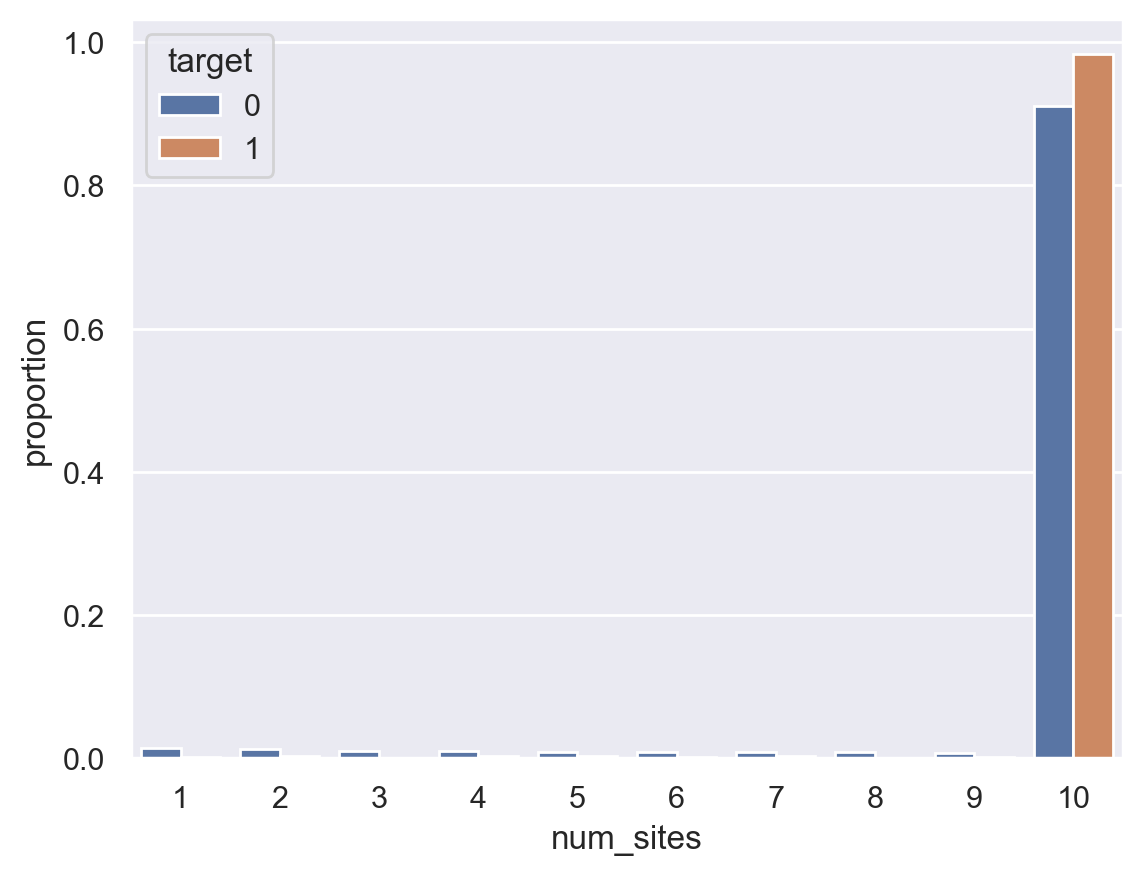

In [209]:
counts = time_df.groupby(['target', 'num_sites']).size().reset_index(name='count')
hue_totals = time_df['target'].value_counts()
counts['proportion'] = counts.apply(lambda row: row['count'] / hue_totals[row['target']], axis=1)

print(counts)
sns.barplot(
    x='num_sites',
    y='proportion',
    hue='target',
    data=counts
)

### Takeaways
- Alice almost exclusively visits 10 sites per session
- Alice visits more sites on average than other users

### Insights
- It may be possible to create a binary feature _10_sites_visited_ (1 when 10 sites visited in a session, 0 otherwise)

In [217]:
time_df

,min_time,max_time,year,month,year_month,day,weekday,hour,num_sites,session_length,avg_time_on_site,target
session_id,,,,,,,,,,,,
21669,2013-01-12 08:05:57,2013-01-12 08:05:57,2013,1,201301,12,5,8,2,0.0,0.000000,0
54843,2013-01-12 08:37:23,2013-01-12 09:07:09,2013,1,201301,12,5,8,4,1786.0,446.500000,0
77292,2013-01-12 08:50:13,2013-01-12 08:50:17,2013,1,201301,12,5,8,10,4.0,0.400000,0
114021,2013-01-12 08:50:17,2013-01-12 08:50:20,2013,1,201301,12,5,8,10,3.0,0.300000,0
146670,2013-01-12 08:50:20,2013-01-12 08:50:22,2013,1,201301,12,5,8,10,2.0,0.200000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
12224,2014-04-30 23:33:48,2014-04-30 23:34:00,2014,4,201404,30,2,23,10,12.0,1.200000,0
164438,2014-04-30 23:34:15,2014-04-30 23:37:13,2014,4,201404,30,2,23,10,178.0,17.800000,0
12221,2014-04-30 23:38:08,2014-04-30 23:38:36,2014,4,201404,30,2,23,10,28.0,2.800000,0


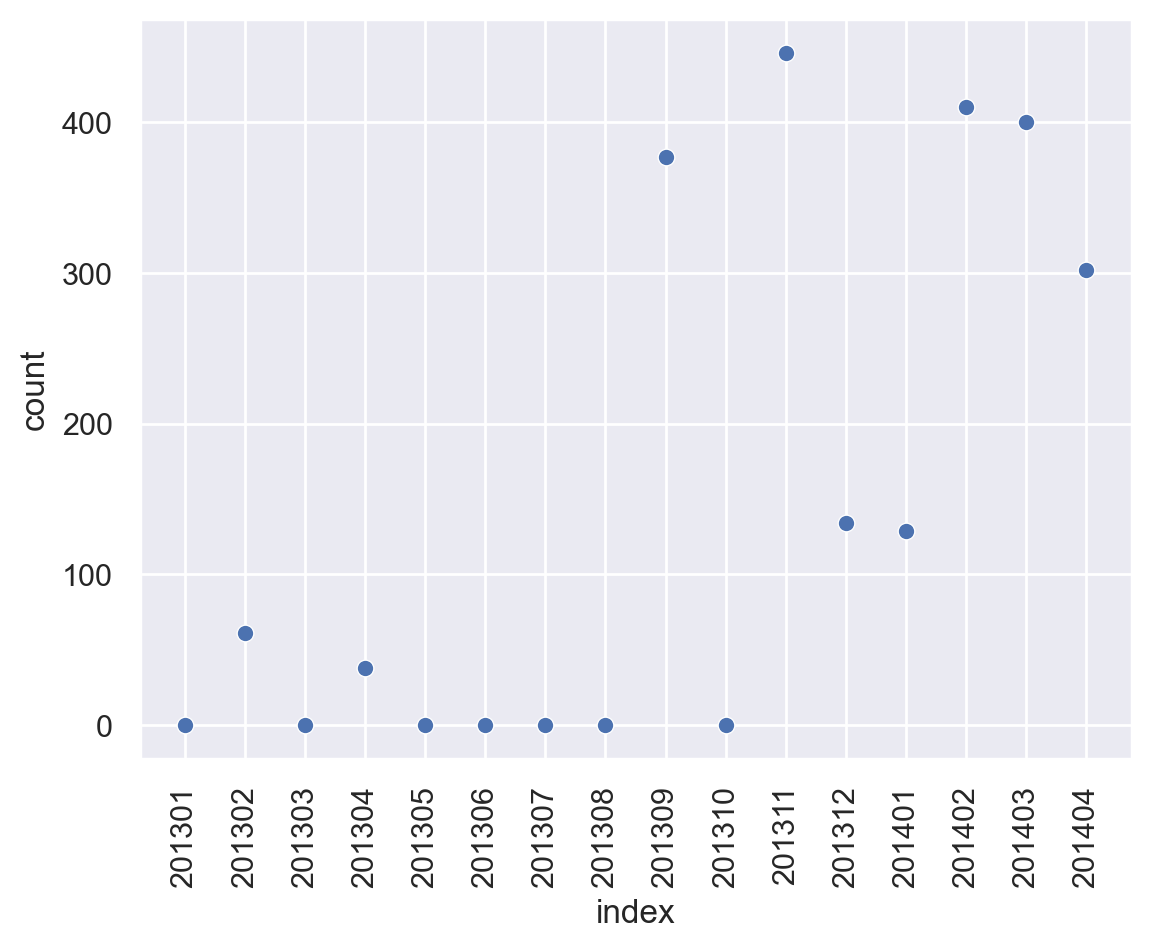

In [269]:
month_target = time_df.groupby(['year_month', 'target']).size()

year_months = time_df['year_month'].unique()
targets = time_df['target'].unique()
complete_index = pd.MultiIndex.from_product([year_months, targets], names=['year_month', 'target'])

month_target_full = month_target.reindex(complete_index, fill_value=0).reset_index(name='count')
sns.scatterplot(
    x='index',
    y='count',
    data=month_target_full[month_target_full['target'] == 1].reset_index(),
)
plt.xticks(range(1, 32, 2), year_months, rotation='vertical');

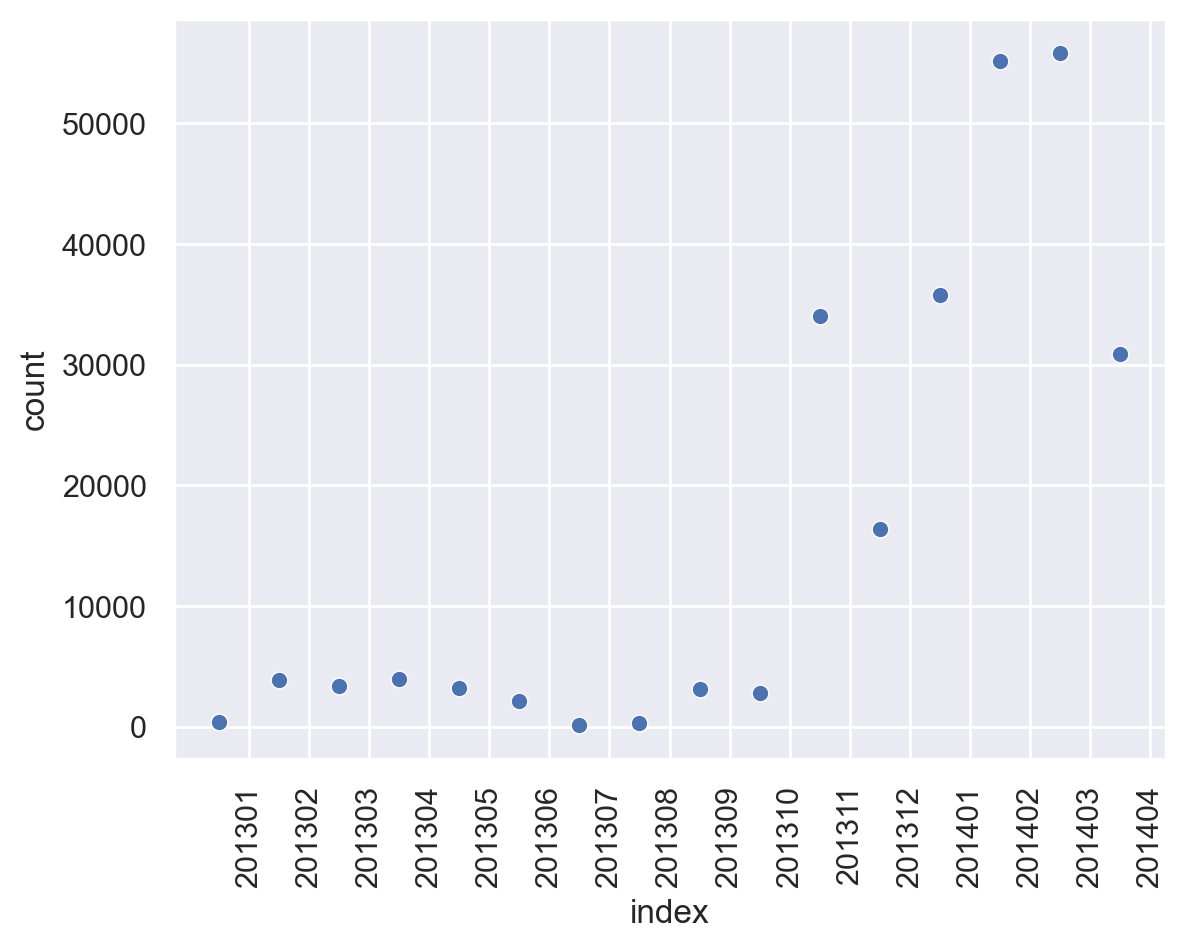

In [271]:
sns.scatterplot(
    x='index',
    y='count',
    data=month_target_full[month_target_full['target'] == 0].reset_index(),
)
plt.xticks(range(1, 32, 2), year_months, rotation='vertical');

### Takeaways
- There is not much difference in when Alice accesses sites the most and the rest of the dataset

In [297]:
weekday_counts = time_df.groupby(['weekday', 'target']).size().reset_index(name='count')
weekday_counts['proportion'] = weekday_counts.apply(lambda row: row['count'] / hue_totals[row['target']], axis=1)
weekday_counts

,weekday,target,count,proportion
0,0,0,39637,0.157750
1,0,1,876,0.381367
2,1,0,48151,0.191635
3,1,1,508,0.221158
4,2,0,55933,0.222607
5,2,1,38,0.016543
6,3,0,43660,0.173761
7,3,1,487,0.212016
8,4,0,40794,0.162355
9,4,1,346,0.150631


<Axes: xlabel='weekday', ylabel='proportion'>

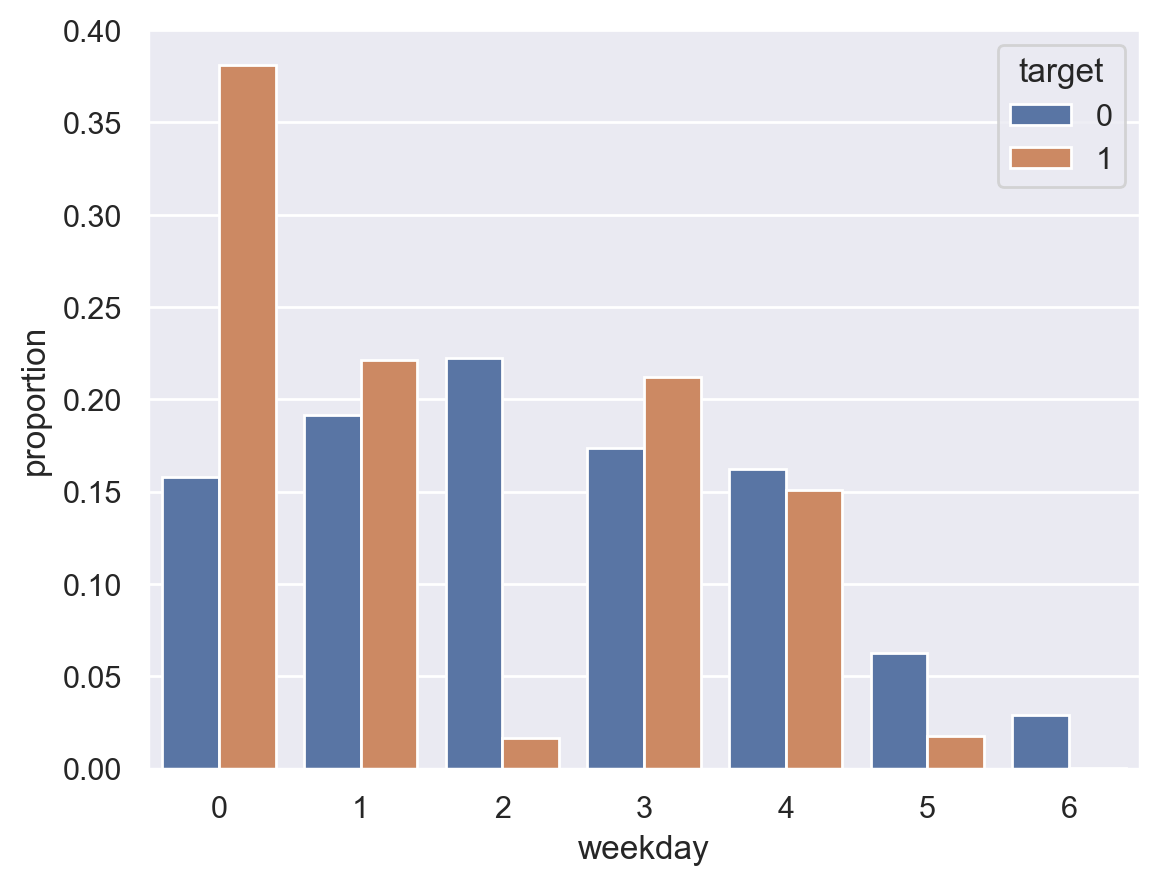

In [299]:
sns.barplot(
    x='weekday',
    y='proportion',
    hue='target',
    data=weekday_counts
)

### Takeaways
- Alice most uses the internet the most on mondays and the least on wednesdays
- Alice never uses the internet on sundays

### Insights
- It may prove valuable to OHE the **weekday** column into seperate features

In [306]:
day_counts = time_df.groupby(['day', 'target']).size().reset_index(name='count')
day_counts['proportion'] = day_counts.apply(lambda row: row['count'] / hue_totals[row['target']], axis=1)
day_counts

,day,target,count,proportion
0,1,0,2,0.000008
1,2,0,4860,0.019342
2,2,1,39,0.016979
3,3,0,4458,0.017742
4,4,0,20164,0.080250
5,4,1,41,0.017849
6,5,0,87,0.000346
7,12,0,28920,0.115098
8,12,1,476,0.207227
9,13,0,8282,0.032961


<Axes: xlabel='day', ylabel='proportion'>

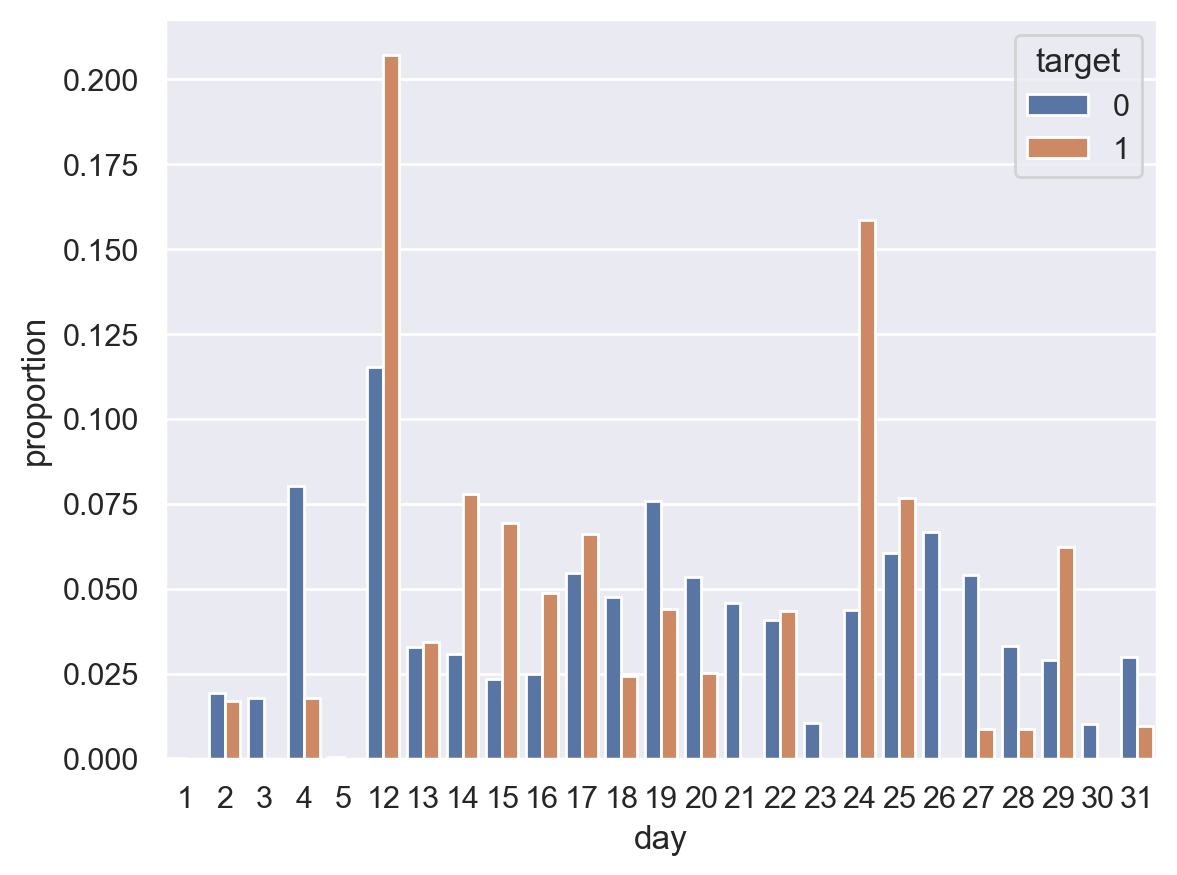

In [318]:
sns.barplot(
    x='day',
    y='proportion',
    hue='target',
    data=day_counts
)

### Takeaways
- Alice uses the internet the most on the 12th and 24th
- There is no data for the 6th-11th day every month

### Insights
- This may prove a useful feature but it might also represent overfitting to the data

In [320]:
hour_counts = time_df.groupby(['hour', 'target']).size().reset_index(name='count')

hours = np.arange(24)
targets = time_df['target'].unique()
complete_index = pd.MultiIndex.from_product([hours, targets], names=['hour', 'target'])
hour_counts = hour_counts.set_index(['hour', 'target']).reindex(complete_index, fill_value=0).reset_index()

hour_counts['proportion'] = hour_counts.apply(lambda row: row['count'] / hue_totals[row['target']], axis=1)
hour_counts

,hour,target,count,proportion
0,0,0,0,0.000000
1,0,1,0,0.000000
2,1,0,0,0.000000
3,1,1,0,0.000000
4,2,0,0,0.000000
5,2,1,0,0.000000
6,3,0,0,0.000000
7,3,1,0,0.000000
8,4,0,0,0.000000
9,4,1,0,0.000000


<Axes: xlabel='hour', ylabel='proportion'>

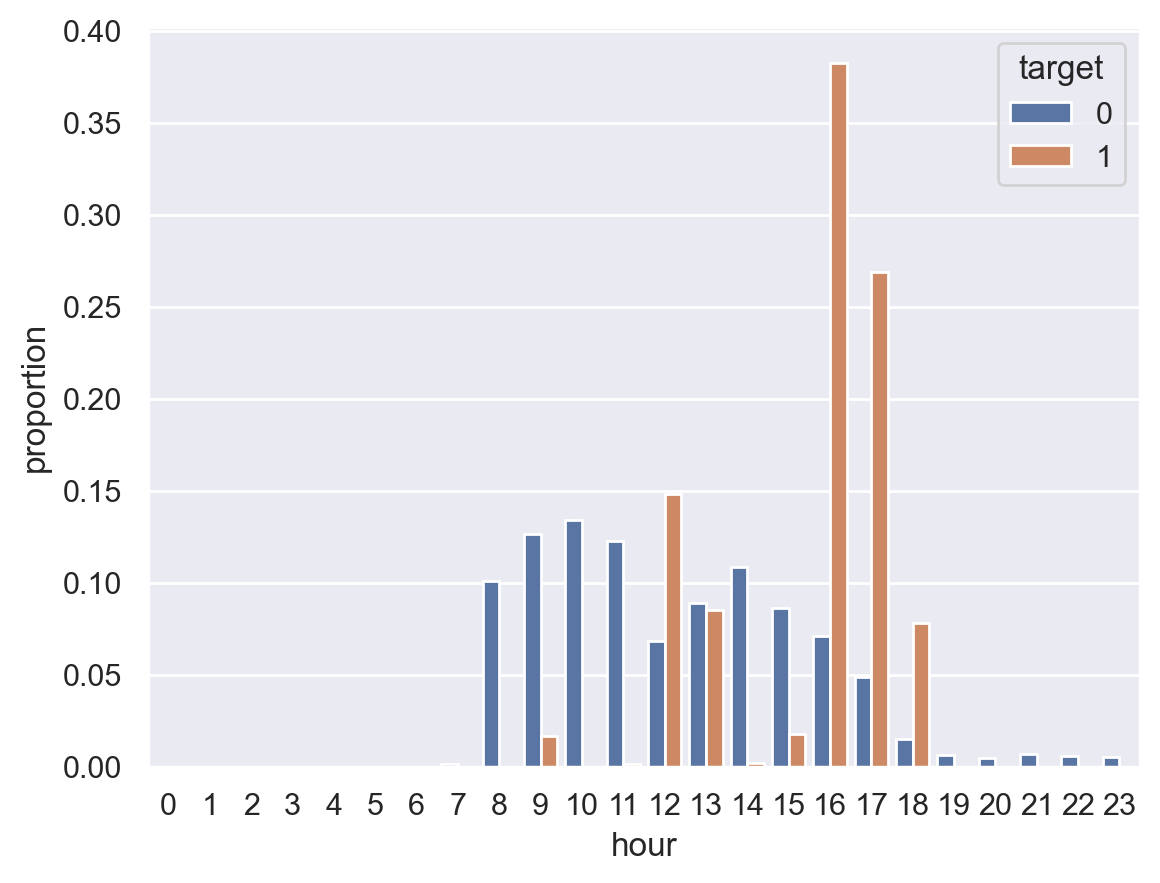

In [322]:
sns.barplot(
    x='hour',
    y='proportion',
    hue='target',
    data=hour_counts
)

### Takeaways
- Alice is most active between 16:00 - 18:00
- Alice has never used the internet between 19:00 and 8:00
- Alice rarely uses the internet in the morning

### Insights
- It would be useful to bin this feature and then OHE the bins
- It could also be possible to just OHE the variable itself but this might overfit to the testing data

## Feature Engineering


I noticed a difference in sites most visited by Alice and the rest of the users. This is intuitively a good way of identifying users as different people use the internet for different purposes i.e. the sites that they visit will different. The best way to do this is by OHE encoded the sites visited in different sessions. Since there are over 48,000 different sites we must use a sparse matrix or else my laptop my implode.

In [385]:
sites_train = train_df[sites].fillna(0).astype('int')
sites_test = test_df[sites].fillna(0).astype('int')

# Step 1: Prepare Data (assuming sites_train and sites_test are already defined)
sites_train_flatten = sites_train.values.flatten()
sites_test_flatten = sites_test.values.flatten()

# Step 2: Create Masks for Non-Zero Site IDs
train_mask = sites_train_flatten != 0
test_mask = sites_test_flatten != 0

# Step 3: Generate Row Indices for Each Session
n_sessions_train, n_sites_per_session = sites_train.shape
n_sessions_test = sites_test.shape[0]

rows_train = np.repeat(np.arange(n_sessions_train), n_sites_per_session)
rows_test = np.repeat(np.arange(n_sessions_test), n_sites_per_session)

# Apply masks to filter valid rows and columns
rows_train_valid = rows_train[train_mask]
cols_train_valid = sites_train_flatten[train_mask]

rows_test_valid = rows_test[test_mask]
cols_test_valid = sites_test_flatten[test_mask]

# Step 4: Identify Unique Sites in Train Data and Create Column Mapping
unique_sites_train = np.unique(cols_train_valid)
site_id_to_col = {site_id: idx for idx, site_id in enumerate(unique_sites_train)}

# Step 5: Map Test Site IDs to Train Columns and Filter
valid_test_mask = np.isin(cols_test_valid, unique_sites_train)
cols_test_valid = np.array([site_id_to_col[site_id] for site_id in cols_test_valid[valid_test_mask]])
rows_test_valid = rows_test_valid[valid_test_mask]

# Step 6: Create Sparse Matrices for Train and Test Data
data_train = np.ones_like(rows_train_valid)
data_test = np.ones_like(rows_test_valid)

sites_train_sparse = csr_matrix(
    (data_train, (rows_train_valid, [site_id_to_col[site_id] for site_id in cols_train_valid])),
    shape=(n_sessions_train, len(unique_sites_train))
)

sites_test_sparse = csr_matrix(
    (data_test, (rows_test_valid, cols_test_valid)),
    shape=(n_sessions_test, len(unique_sites_train))
)

I will use this sparse matrix to test a LogisticRegressor and use its accuracy as a baseline for future models and features. Initially I will use 90% of the data to test the model and the remaining 10% for validation

In [437]:
X_train, X_valid, y_train, y_valid = train_test_split(sites_train_sparse, train_df['target'], test_size=0.1, random_state=14)

In [605]:
lr = LogisticRegression(random_state=14, solver='liblinear')
lr.fit(X_train, y_train)
predictions = lr.predict_proba(X_valid)[:,1]
baseline = roc_auc_score(y_valid, predictions)
baseline

0.9650083953821732

Without engineering any additional features or tuning model. I retest the model on the whole dataset and submit it to Kaggle to get a better understanding of how much I need to improve the model

In [456]:
lr.fit(sites_train_sparse, train_df['target'])
predictions = lr.predict_proba(sites_test_sparse)[:, 1]

def write_to_submission_file(pred_labels, out_file, target='target', index_label='session_id'):
    predicted_df = pd.DataFrame(
        pred_labels,
        index=np.arange(1, pred_labels.shape[0] + 1),
        columns=[target]
    )
    predicted_df.to_csv(out_file, index_label=index_label)

write_to_submission_file(predictions, 'submission1.csv')

The model achieved a score of .908 on the public leaderboard. The goal is to get the model to at least .95216. Let's keep going

In [476]:
work_df_train = pd.DataFrame(index=train_df.index)
work_df_train['min_time'] = train_df[times].min(axis=1)
work_df_train['max_time'] = train_df[times].max(axis=1)
work_df_train['year'] = work_df_train['min_time'].dt.year
work_df_train['month'] = work_df_train['min_time'].dt.month
work_df_train['year_month'] = work_df_train['year'] * 100 + work_df_train['month']
work_df_train['day'] = work_df_train['min_time'].dt.day
work_df_train['weekday'] = work_df_train['min_time'].dt.weekday
work_df_train['weekday_name'] = work_df_train['min_time'].dt.day_name()
work_df_train['hour'] = work_df_train['min_time'].dt.hour
work_df_train['num_sites'] = train_df[sites].apply(lambda x: x.count(), axis=1)
work_df_train['n_unique_sites'] = train_df[sites].apply(lambda x: x.nunique(), axis=1)
work_df_train['unique_total_ratio'] = work_df_train['n_unique_sites'] / work_df_train['num_sites']
work_df_train['session_length'] = (work_df_train['max_time'] - work_df_train['min_time']) / np.timedelta64(1, "s")
work_df_train['avg_time_on_site'] = work_df_train['session_length'] / work_df_train['num_sites']
work_df_train['is_10_visited'] = work_df_train['num_sites'].apply(lambda x: 1 if x == 10 else 0)
work_df_train['target'] = train_df['target']

In [477]:
work_df_train

,min_time,max_time,year,month,year_month,day,weekday,hour,num_sites,n_unique_sites,session_length,avg_time_on_site,target
session_id,,,,,,,,,,,,,
21669,2013-01-12 08:05:57,2013-01-12 08:05:57,2013,1,201301,12,5,8,2,2,0.0,0.000000,0
54843,2013-01-12 08:37:23,2013-01-12 09:07:09,2013,1,201301,12,5,8,4,2,1786.0,446.500000,0
77292,2013-01-12 08:50:13,2013-01-12 08:50:17,2013,1,201301,12,5,8,10,6,4.0,0.400000,0
114021,2013-01-12 08:50:17,2013-01-12 08:50:20,2013,1,201301,12,5,8,10,5,3.0,0.300000,0
146670,2013-01-12 08:50:20,2013-01-12 08:50:22,2013,1,201301,12,5,8,10,6,2.0,0.200000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12224,2014-04-30 23:33:48,2014-04-30 23:34:00,2014,4,201404,30,2,23,10,6,12.0,1.200000,0
164438,2014-04-30 23:34:15,2014-04-30 23:37:13,2014,4,201404,30,2,23,10,7,178.0,17.800000,0
12221,2014-04-30 23:38:08,2014-04-30 23:38:36,2014,4,201404,30,2,23,10,8,28.0,2.800000,0


In [470]:
work_df_test = pd.DataFrame(index=test_df.index)
work_df_test['min_time'] = test_df[times].min(axis=1)
work_df_test['max_time'] = test_df[times].max(axis=1)
work_df_test['year'] = work_df_test['min_time'].dt.year
work_df_test['month'] = work_df_test['min_time'].dt.month
work_df_test['year_month'] = work_df_test['year'] * 100 + work_df_test['month']
work_df_test['day'] = work_df_test['min_time'].dt.day
work_df_test['weekday'] = work_df_test['min_time'].dt.weekday
work_df_test['weekday_name'] = work_df_test['min_time'].dt.day_name()
work_df_test['hour'] = work_df_test['min_time'].dt.hour
work_df_test['num_sites'] = test_df[sites].apply(lambda x: x.count(), axis=1)
work_df_test['n_unique_sites'] = test_df[sites].apply(lambda x: x.nunique(), axis=1)
work_df_test['unique_total_ratio'] = work_df_test['n_unique_sites'] / work_df_test['num_sites']
work_df_test['session_length'] = (work_df_test['max_time'] - work_df_test['min_time']) / np.timedelta64(1, "s")
work_df_test['avg_time_on_site'] = work_df_test['session_length'] / work_df_test['num_sites']


In [471]:
work_df_test

,min_time,max_time,year,month,year_month,day,weekday,hour,num_sites,n_unique_sites,session_length,avg_time_on_site
session_id,,,,,,,,,,,,
1,2014-10-04 11:19:53,2014-10-04 11:20:00,2014,10,201410,4,5,11,10,10,7.0,0.7
2,2014-07-03 11:00:28,2014-07-03 11:01:53,2014,7,201407,3,3,11,10,1,85.0,8.5
3,2014-12-05 15:55:12,2014-12-05 15:56:36,2014,12,201412,5,4,15,10,2,84.0,8.4
4,2014-11-04 10:03:19,2014-11-04 10:03:23,2014,11,201411,4,1,10,10,7,4.0,0.4
5,2014-05-16 15:05:31,2014-05-16 15:05:44,2014,5,201405,16,4,15,10,8,13.0,1.3
...,...,...,...,...,...,...,...,...,...,...,...,...
82793,2014-10-02 18:20:09,2014-10-02 18:20:09,2014,10,201410,2,3,18,3,3,0.0,0.0
82794,2014-05-26 14:16:40,2014-05-26 14:17:19,2014,5,201405,26,0,14,10,6,39.0,3.9
82795,2014-05-02 11:21:56,2014-05-02 11:22:04,2014,5,201405,2,4,11,10,10,8.0,0.8


In [531]:
def get_roc_auc(X, y, C=1, test_size=0.1, random_state=14):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=random_state)
    lr = LogisticRegression(C=C, random_state=14, solver='liblinear')
    lr.fit(X_train, y_train)
    predictions = lr.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, predictions)

Adding weekday OHE improves the model

In [635]:
weekday_OHE_train = pd.get_dummies(work_df_train['weekday_name'], columns=['weekday_name']).astype('int')

sparse_weekday = csr_matrix(hstack([sites_train_sparse, weekday_OHE_train]))
get_roc_auc(sparse_weekday, train_df['target']) - baseline

0.00886931799434687

In [617]:
sparse_10_visited = csr_matrix(hstack([sites_train_sparse, work_df_train[['is_10_visited']]]))
get_roc_auc(sparse_10_visited, train_df['target']) - baseline

-0.0002447125589783994

In [788]:
scaler = StandardScaler()

start_hour_scaled = scaler.fit_transform(work_df_train[['hour']])
start_hour_log_scaled = scaler.fit_transform(np.log(work_df_train[['hour']] + 1))
year_month_scaled = scaler.fit_transform(work_df_train[['year_month']])
year_month_log_scaled = scaler.fit_transform(np.log(work_df_train[['year_month']]))
session_length_scaled = scaler.fit_transform(work_df_train[['session_length']])
session_length_log_scaled = scaler.fit_transform(np.log(work_df_train[['session_length']] + 1))
day_scaled = scaler.fit_transform(work_df_train[['day']])
day_log_scaled = scaler.fit_transform(np.log(work_df_train[['day']]))
month_scaled = scaler.fit_transform(work_df_train[['month']])
month_log_scaled = scaler.fit_transform(np.log(work_df_train[['month']]))

features = [start_hour_scaled, start_hour_log_scaled, year_month_scaled, year_month_log_scaled, session_length_scaled, session_length_log_scaled,
            day_scaled, day_log_scaled, month_scaled, month_log_scaled]
for i, feature in enumerate(features):
    tmp = csr_matrix(hstack([sites_train_sparse, feature]))
    score = get_roc_auc(tmp, train_df['target'])
    print(f'round {i} score: {score}')
    print(f'score - baseline: {score - baseline}')

round 0 score: 0.9753813666509024
score - baseline: 0.010372971268729159
round 1 score: 0.9760513474771694
score - baseline: 0.011042952094996172
round 2 score: 0.9668145940337796
score - baseline: 0.001806198651606361
round 3 score: 0.9668145940337796
score - baseline: 0.001806198651606361
round 4 score: 0.9649837408209878
score - baseline: -2.465456118538878e-05
round 5 score: 0.9647980525646243
score - baseline: -0.00021034281754894746
round 6 score: 0.9646427013333626
score - baseline: -0.0003656940488105942
round 7 score: 0.9650628370525977
score - baseline: 5.444167042445436e-05
round 8 score: 0.9680350406387823
score - baseline: 0.0030266452566091173
round 9 score: 0.9686758759243169
score - baseline: 0.0036674805421437195


In [660]:
sp = csr_matrix(
    hstack([
        sites_train_sparse,
        weekday_OHE_train,
        start_hour_log_scaled,
        year_month_scaled,
        month_log_scaled])
)
get_roc_auc(sp, train_df['target'])

0.9830625914235122

Model shows much better results when adding hour log scaled, year_month scaled, and month log scaled
I am curious if these features would prove more useful when OHE.

In [661]:
year_month_OHE_train = pd.get_dummies(work_df_train['year_month'], columns=['year_month']).astype('int')
start_hour_OHE_train = pd.get_dummies(work_df_train['hour'], columns=['hour']).astype('int')
month_OHE_train = pd.get_dummies(work_df_train['month'], columns=['month']).astype('int')

sp = csr_matrix(
    hstack([
        sites_train_sparse,
        weekday_OHE_train,
        start_hour_OHE_train,
        year_month_OHE_train,
        month_OHE_train])
)
get_roc_auc(sp, train_df['target'])

0.9896049404441121

In [784]:
sp = csr_matrix(
    hstack([
        sites_train_sparse,
        weekday_OHE_train,
        start_hour_OHE_train,
        start_hour_log_scaled,
        year_month_scaled,
        month_log_scaled])
)
get_roc_auc(sp, train_df['target'])

0.9883150211350996

roc_auc is close to .99, let's perform the same transformations on the test set and submit the model.

In [786]:
weekday_OHE_test = pd.get_dummies(work_df_test['weekday_name'], columns=['weekday_name']).astype('int')
start_hour_log_scaled_test = scaler.fit_transform(np.log(work_df_test[['hour']] + 1))
year_month_scaled_test = scaler.fit_transform(work_df_test[['year_month']])
month_log_scaled_test = scaler.fit_transform(np.log(work_df_test[['month']]))
year_month_OHE_test = pd.get_dummies(work_df_test['year_month'], columns=['year_month']).astype('int')
start_hour_OHE_test = pd.get_dummies(work_df_test['hour'], columns=['hour']).astype('int')
month_OHE_test = pd.get_dummies(work_df_test['month'], columns=['month']).astype('int')

sp_train = csr_matrix(
    hstack([
        sites_train_sparse,
        weekday_OHE_train,
        start_hour_OHE_train,
        start_hour_log_scaled,
        year_month_scaled,
        month_log_scaled])
)

sp_test = csr_matrix(
    hstack([
        sites_test_sparse,
        weekday_OHE_test,
        start_hour_OHE_test,
        start_hour_log_scaled_test,
        year_month_scaled_test,
        month_log_scaled_test])
)

In [703]:
sp_train.shape, sp_test.shape

((253561, 41656), (82797, 41644))

In [710]:
weekday_OHE_train, start_hour_OHE_train, year_month_OHE_train, month_OHE_train

(            Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday
 session_id                                                                
 21669            0       0         1       0         0        0          0
 54843            0       0         1       0         0        0          0
 77292            0       0         1       0         0        0          0
 114021           0       0         1       0         0        0          0
 146670           0       0         1       0         0        0          0
 ...            ...     ...       ...     ...       ...      ...        ...
 12224            0       0         0       0         0        0          1
 164438           0       0         0       0         0        0          1
 12221            0       0         0       0         0        0          1
 156968           0       0         0       0         0        0          1
 204762           0       0         0       0         0        0          1
 
 [253561 r

In [712]:
weekday_OHE_test, start_hour_OHE_test, year_month_OHE_test, month_OHE_test

(            Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday
 session_id                                                                
 1                0       0         1       0         0        0          0
 2                0       0         0       0         1        0          0
 3                1       0         0       0         0        0          0
 4                0       0         0       0         0        1          0
 5                1       0         0       0         0        0          0
 ...            ...     ...       ...     ...       ...      ...        ...
 82793            0       0         0       0         1        0          0
 82794            0       1         0       0         0        0          0
 82795            1       0         0       0         0        0          0
 82796            0       0         1       0         0        0          0
 82797            0       0         0       1         0        0          0
 
 [82797 ro

In [696]:
te = [weekday_OHE_test,
      start_hour_OHE_test,
      start_hour_log_scaled_test,
      year_month_scaled_test,
      month_log_scaled_test]
tr = [weekday_OHE_train,
      start_hour_OHE_train,
      start_hour_log_scaled,
      year_month_scaled,
      month_log_scaled]

for test, train in zip(te, tr):
    print(test.shape, train.shape)

(82797, 7) (253561, 7)
(82797, 17) (253561, 17)
(82797, 1) (253561, 1)
(82797, 1) (253561, 1)
(82797, 1) (253561, 1)


In [720]:
lr.fit(sp_train, train_df['target'])
predictions = lr.predict_proba(sp_test)[:, 1]

def write_to_submission_file(pred_labels, out_file, target='target', index_label='session_id'):
    predicted_df = pd.DataFrame(
        pred_labels,
        index=np.arange(1, pred_labels.shape[0] + 1),
        columns=[target]
    )
    predicted_df.to_csv(out_file, index_label=index_label)

write_to_submission_file(predictions, 'submission2.csv')

This model gets .945 on public leaderboard. Closer. Maybe with parameter hypertuning we can get the last .01

In [733]:
time_split = TimeSeriesSplit(n_splits=10)
cv = time_split.split(sp_train)
params = {
    'C': np.logspace(-2, 2, 10)
}

lr_grid_search = GridSearchCV(estimator=lr, param_grid=params, scoring='roc_auc', cv=cv, verbose=2)
lr_grid_search.fit(sp_train, train_df['target'])

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END .............................................C=0.01; total time=   0.1s
[CV] END .............................................C=0.01; total time=   0.1s
[CV] END .............................................C=0.01; total time=   0.2s
[CV] END .............................................C=0.01; total time=   0.3s
[CV] END .............................................C=0.01; total time=   0.4s
[CV] END .............................................C=0.01; total time=   0.5s
[CV] END .............................................C=0.01; total time=   0.6s
[CV] END .............................................C=0.01; total time=   0.7s
[CV] END .............................................C=0.01; total time=   0.9s
[CV] END .............................................C=0.01; total time=   0.9s
[CV] END .............................C=0.027825594022071243; total time=   0.1s
[CV] END .............................C=0.0278

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x16e760e00>,
             estimator=LogisticRegression(random_state=14, solver='liblinear'),
             param_grid={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])},
             scoring='roc_auc', verbose=2)

In [735]:
lr_grid_search.best_score_, lr_grid_search.best_params_

(0.919098156581408, {'C': 1.6681005372000592})

In [737]:
lr = LogisticRegression(C=1.6681005372000592, random_state=17, solver='liblinear')
lr.fit(sp_train, train_df['target'])
predictions = lr.predict_proba(sp_test)[:, 1]

def write_to_submission_file(pred_labels, out_file, target='target', index_label='session_id'):
    predicted_df = pd.DataFrame(
        pred_labels,
        index=np.arange(1, pred_labels.shape[0] + 1),
        columns=[target]
    )
    predicted_df.to_csv(out_file, index_label=index_label)

write_to_submission_file(predictions, 'submission3.csv')

tuning C did not lead to a increased performance on the test data. From my EDA I think there must be a way to engineer some of the time data relating to length of session, num sessions, etc. to create valuable features

In [820]:
session_data_train = pd.DataFrame(index=train_df.index)
session_data_train['min_time'] = train_df[times].min(axis=1)
session_data_train['max_time'] = train_df[times].max(axis=1)
session_data_train['num_sites'] = train_df[sites].apply(lambda x: x.count(), axis=1)
session_data_train['n_unique_sites'] = train_df[sites].apply(lambda x: x.nunique(), axis=1)
session_data_train['unique_total_ratio'] = session_data_train['n_unique_sites'] / session_data_train['num_sites']
session_data_train['session_length'] = (session_data_train['max_time'] - session_data_train['min_time']) / np.timedelta64(1, "s")
session_data_train['avg_time_on_site'] = session_data_train['session_length'] / session_data_train['num_sites']
session_data_train['target'] = train_df['target']

session_data_train

,min_time,max_time,num_sites,n_unique_sites,unique_total_ratio,session_length,avg_time_on_site,target
session_id,,,,,,,,
21669,2013-01-12 08:05:57,2013-01-12 08:05:57,2,2,1.000000,0.0,0.000000,0
54843,2013-01-12 08:37:23,2013-01-12 09:07:09,4,2,0.500000,1786.0,446.500000,0
77292,2013-01-12 08:50:13,2013-01-12 08:50:17,10,6,0.600000,4.0,0.400000,0
114021,2013-01-12 08:50:17,2013-01-12 08:50:20,10,5,0.500000,3.0,0.300000,0
146670,2013-01-12 08:50:20,2013-01-12 08:50:22,10,6,0.600000,2.0,0.200000,0
...,...,...,...,...,...,...,...,...
12224,2014-04-30 23:33:48,2014-04-30 23:34:00,10,6,0.600000,12.0,1.200000,0
164438,2014-04-30 23:34:15,2014-04-30 23:37:13,10,7,0.700000,178.0,17.800000,0
12221,2014-04-30 23:38:08,2014-04-30 23:38:36,10,8,0.800000,28.0,2.800000,0


In [772]:
time_spent_train = pd.DataFrame(index=train_df.index)
for i in range(1, 10):
    time_spent_train[f'time_diff_{i}_{i+1}'] = (train_df[f'time{i+1}'] - train_df[f'time{i}']) / np.timedelta64(1, 's')
time_spent_train['target'] = train_df['target']
time_spent_train

,time_diff_1_2,time_diff_2_3,time_diff_3_4,time_diff_4_5,time_diff_5_6,time_diff_6_7,time_diff_7_8,time_diff_8_9,time_diff_9_10,target
session_id,,,,,,,,,,
21669,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
54843,0.0,1784.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0
77292,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
114021,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
146670,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
12224,1.0,3.0,0.0,1.0,0.0,1.0,0.0,3.0,3.0,0
164438,1.0,1.0,1.0,0.0,58.0,13.0,43.0,30.0,31.0,0
12221,2.0,3.0,5.0,4.0,2.0,11.0,0.0,0.0,1.0,0


In [807]:
t = session_data_train['session_length'].apply(lambda x: 1 if x < 20 else 0)
t_reshaped = csr_matrix(t.values.reshape(-1, 1))
tmp = csr_matrix(hstack([sites_train_sparse, t_reshaped]))
get_roc_auc(tmp, train_df['target'])

0.9647507598004172

In [897]:
time_spent_train['median_time_spent'] = time_spent_train.apply(lambda row: row.median(), axis=1)

In [898]:
time_spent_train.groupby('target')['median_time_spent'].describe().T

target,0,1
count,251264.000000,2297.000000
mean,4.800694,1.536569
std,26.790407,7.579311
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,1.000000
75%,1.500000,1.000000
max,900.000000,262.000000


In [901]:
t_reshaped = csr_matrix(time_spent_train['median_time_spent'].values.reshape(-1, 1))
tmp = csr_matrix(hstack([sites_train_sparse, t_reshaped]))
get_roc_auc(tmp, train_df['target'])

0.9650031711814759

In [902]:
time_spent_train['max_time_spent'] = time_spent_train.apply(lambda row: row.max(), axis=1)
time_spent_train.groupby('target')['max_time_spent'].describe().T

target,0,1
count,251264.000000,2297.000000
mean,87.492880,31.809752
std,221.818016,111.434564
min,0.000000,1.000000
25%,2.000000,2.000000
50%,13.000000,5.000000
75%,55.000000,18.000000
max,1800.000000,1746.000000


In [903]:
t_reshaped = csr_matrix(time_spent_train['max_time_spent'].values.reshape(-1, 1))
tmp = csr_matrix(hstack([sites_train_sparse, t_reshaped]))
get_roc_auc(tmp, train_df['target'])

0.9650055541502149

In [904]:
time_spent_train['min_time_spent'] = time_spent_train.apply(lambda row: row.min(), axis=1)
time_spent_train.groupby('target')['min_time_spent'].describe().T

target,0,1
count,251264.0,2297.000000
mean,0.0,0.068785
std,0.0,0.253144
min,0.0,0.000000
25%,0.0,0.000000
50%,0.0,0.000000
75%,0.0,0.000000
max,0.0,1.000000


In [905]:
t_reshaped = csr_matrix(time_spent_train['min_time_spent'].values.reshape(-1, 1))
tmp = csr_matrix(hstack([sites_train_sparse, t_reshaped]))
get_roc_auc(tmp, train_df['target'])

0.9690797891255971

In [915]:
# percent sites 0 seconds
time_spent_train['num_sites_0_seconds'] = time_spent_train.apply(lambda row: (row == 0).sum(), axis=1)
time_spent_train['percent_0_seconds'] = time_spent_train['num_sites_0_seconds'] / session_data_train['num_sites']

In [916]:
time_spent_train.groupby('target')['num_sites_0_seconds'].describe().T

target,0,1
count,251264.000000,2297.000000
mean,5.735744,5.422290
std,2.825628,2.513758
min,2.000000,1.000000
25%,3.000000,4.000000
50%,5.000000,5.000000
75%,8.000000,8.000000
max,13.000000,11.000000


In [917]:
time_spent_train.groupby('target')['percent_0_seconds'].describe().T

target,0,1
count,251264.000000,2297.000000
mean,0.660249,0.547273
std,0.507633,0.249516
min,0.200000,0.100000
25%,0.400000,0.400000
50%,0.600000,0.500000
75%,0.900000,0.800000
max,4.000000,1.100000


In [918]:
t_reshaped = csr_matrix(time_spent_train['num_sites_0_seconds'].values.reshape(-1, 1))
tmp = csr_matrix(hstack([sites_train_sparse, t_reshaped]))
get_roc_auc(tmp, train_df['target'])

0.9709071595379241

In [919]:
t_reshaped = csr_matrix(time_spent_train['percent_0_seconds'].values.reshape(-1, 1))
tmp = csr_matrix(hstack([sites_train_sparse, t_reshaped]))
get_roc_auc(tmp, train_df['target'])

0.970829621401259

In [920]:
n_0_sec_scaled = scaler.fit_transform(time_spent_train[['num_sites_0_seconds']])
n_0_sec_log_scaled = scaler.fit_transform(np.log(time_spent_train[['num_sites_0_seconds']] + 1))
percent_0_sec_scaled = scaler.fit_transform(time_spent_train[['percent_0_seconds']])
percent_0_sec_log_scaled = scaler.fit_transform(np.log(time_spent_train[['percent_0_seconds']] + 1))

features = [n_0_sec_scaled, n_0_sec_log_scaled, percent_0_sec_scaled, percent_0_sec_log_scaled]
for i, feature in enumerate(features):
    tmp = csr_matrix(hstack([sites_train_sparse, feature]))
    score = get_roc_auc(tmp, train_df['target'])
    print(f'round {i} score: {score}')
    print(f'score - baseline: {score - baseline}')

round 0 score: 0.9708692153433858
score - baseline: 0.005860819961212571
round 1 score: 0.9709249401508235
score - baseline: 0.005916544768650334
round 2 score: 0.9708250387690684
score - baseline: 0.005816643386895248
round 3 score: 0.9706815107288584
score - baseline: 0.005673115346685242


In [921]:
sp = csr_matrix(
    hstack([
        sites_train_sparse,
        weekday_OHE_train,
        start_hour_OHE_train,
        start_hour_log_scaled,
        year_month_scaled,
        month_log_scaled])
)

for i, feature in enumerate(features):
    tmp = csr_matrix(hstack([sp, feature]))
    score = get_roc_auc(tmp, train_df['target'])
    print(f'round {i} score: {score}')
    print(f'score - baseline: {score - baseline}')

round 0 score: 0.9898368216329568
score - baseline: 0.02482842625078363
round 1 score: 0.9899666017765948
score - baseline: 0.02495820639442159
round 2 score: 0.9898996953466119
score - baseline: 0.02489129996443873
round 3 score: 0.9898764155750837
score - baseline: 0.024868020192910456


In [922]:
sp_train = csr_matrix(
    hstack([
        sites_train_sparse,
        weekday_OHE_train,
        start_hour_OHE_train,
        year_month_scaled,
        month_log_scaled,
        percent_0_sec_log_scaled])
)
get_roc_auc(sp, train_df['target'])

0.9899042779788025

GENIUS MANUEVERS FROM BOY WONDER

adding some extra time features

In [924]:
def add_time_features(df, X_sparse):
    hour = df['time1'].apply(lambda ts: ts.hour)
    morning = ((hour >= 7) & (hour <= 11)).astype('int')
    day = ((hour >= 12) & (hour <= 18)).astype('int')
    evening = ((hour >= 19) & (hour <= 23)).astype('int')
    night = ((hour >= 0) & (hour <= 6)).astype('int')
    X = hstack([X_sparse, morning.values.reshape(-1, 1), 
                day.values.reshape(-1, 1), evening.values.reshape(-1, 1), 
                night.values.reshape(-1, 1)])
    return X

big_boy = add_time_features(train_df, sp)
get_roc_auc(big_boy, train_df['target'])

0.9898470867290637

In [925]:
time_split = TimeSeriesSplit(n_splits=10)
cv = time_split.split(big_boy)
params = {
    'C': np.logspace(-2, 2, 10)
}

lr_grid_search = GridSearchCV(estimator=lr, param_grid=params, scoring='roc_auc', cv=cv, verbose=2)
lr_grid_search.fit(big_boy, train_df['target'])

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END .............................................C=0.01; total time=   0.1s
[CV] END .............................................C=0.01; total time=   0.2s
[CV] END .............................................C=0.01; total time=   0.3s
[CV] END .............................................C=0.01; total time=   0.4s
[CV] END .............................................C=0.01; total time=   0.5s
[CV] END .............................................C=0.01; total time=   0.6s
[CV] END .............................................C=0.01; total time=   0.7s
[CV] END .............................................C=0.01; total time=   0.9s
[CV] END .............................................C=0.01; total time=   1.2s
[CV] END .............................................C=0.01; total time=   1.2s
[CV] END .............................C=0.027825594022071243; total time=   0.1s
[CV] END .............................C=0.0278

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x17197d640>,
             estimator=LogisticRegression(C=1.6681005372000592, random_state=17,
                                          solver='liblinear'),
             param_grid={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])},
             scoring='roc_auc', verbose=2)

In [928]:
lr_grid_search.best_score_, lr_grid_search.best_params_

(0.9248129893567546, {'C': 0.5994842503189409})

In [948]:
time_spent_test = pd.DataFrame(index=test_df.index)
for i in range(1, 10):
    time_spent_test[f'time_diff_{i}_{i+1}'] = (test_df[f'time{i+1}'] - test_df[f'time{i}']) / np.timedelta64(1, 's')
time_spent_test['num_sites_0_seconds'] = time_spent_test.apply(lambda row: (row == 0).sum(), axis=1)
time_spent_test['percent_0_seconds'] = time_spent_test['num_sites_0_seconds'] / work_df_test['num_sites']
n_0_sec_scaled_test = scaler.fit_transform(time_spent_test[['num_sites_0_seconds']])
n_0_sec_log_scaled_test = scaler.fit_transform(np.log(time_spent_test[['num_sites_0_seconds']] + 1))
percent_0_sec_scaled_test = scaler.fit_transform(time_spent_test[['percent_0_seconds']])
percent_0_sec_log_scaled_test = scaler.fit_transform(np.log(time_spent_test[['percent_0_seconds']] + 1))
time_spent_test

,time_diff_1_2,time_diff_2_3,time_diff_3_4,time_diff_4_5,time_diff_5_6,time_diff_6_7,time_diff_7_8,time_diff_8_9,time_diff_9_10,num_sites_0_seconds,percent_0_seconds
session_id,,,,,,,,,,,
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,7,0.700000
2,25.0,5.0,8.0,3.0,1.0,13.0,6.0,1.0,23.0,0,0.000000
3,1.0,1.0,61.0,1.0,1.0,1.0,1.0,14.0,3.0,0,0.000000
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,5,0.500000
5,1.0,1.0,6.0,1.0,0.0,0.0,0.0,0.0,4.0,4,0.400000
...,...,...,...,...,...,...,...,...,...,...,...
82793,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0.666667
82794,1.0,3.0,0.0,35.0,0.0,0.0,0.0,0.0,0.0,6,0.600000
82795,0.0,0.0,7.0,0.0,0.0,0.0,1.0,0.0,0.0,7,0.700000


In [949]:
percent_0_sec_log_scaled_test.shape

(82797, 1)

In [950]:


sp_train = csr_matrix(
    hstack([
        sites_train_sparse,
        weekday_OHE_train,
        start_hour_OHE_train,
        year_month_scaled,
        month_log_scaled,
        percent_0_sec_log_scaled])
)

sp_test = csr_matrix(
    hstack([
        sites_test_sparse,
        weekday_OHE_test,
        start_hour_OHE_test,
        year_month_scaled_test,
        month_log_scaled_test,
        percent_0_sec_log_scaled_test])
)

In [957]:
sp2_train = csr_matrix(
    hstack([
        sites_train_sparse,
        weekday_OHE_train,
        percent_0_sec_log_scaled])
)

sp2_test = csr_matrix(
    hstack([
        sites_test_sparse,
        weekday_OHE_test,
        percent_0_sec_log_scaled_test])
)

In [959]:
lr.fit(sp_train, train_df['target'])
predictions = lr.predict_proba(sp_test)[:, 1]

def write_to_submission_file(pred_labels, out_file, target='target', index_label='session_id'):
    predicted_df = pd.DataFrame(
        pred_labels,
        index=np.arange(1, pred_labels.shape[0] + 1),
        columns=[target]
    )
    predicted_df.to_csv(out_file, index_label=index_label)

write_to_submission_file(predictions, 'submission5.csv')

In [963]:
lr.fit(sp2_train, train_df['target'])
predictions = lr.predict_proba(sp2_test)[:, 1]

def write_to_submission_file(pred_labels, out_file, target='target', index_label='session_id'):
    predicted_df = pd.DataFrame(
        pred_labels,
        index=np.arange(1, pred_labels.shape[0] + 1),
        columns=[target]
    )
    predicted_df.to_csv(out_file, index_label=index_label)

write_to_submission_file(predictions, 'submission6.csv')

In [967]:
big_boy_train = add_time_features(train_df, sp_train)
big_boy_test = add_time_features(test_df, sp_test)
get_roc_auc(big_boy_train, train_df['target'])

0.9898470867290637

In [973]:
lr = LogisticRegression(C=0.5994842503189409, random_state=17, solver='liblinear')
lr.fit(big_boy_train, train_df['target'])
predictions = lr.predict_proba(big_boy_test)[:, 1]

def write_to_submission_file(pred_labels, out_file, target='target', index_label='session_id'):
    predicted_df = pd.DataFrame(
        pred_labels,
        index=np.arange(1, pred_labels.shape[0] + 1),
        columns=[target]
    )
    predicted_df.to_csv(out_file, index_label=index_label)

write_to_submission_file(predictions, 'submission7.csv')